In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import re
import warnings
warnings.filterwarnings('ignore')

# Try to import XGBoost and LightGBM
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed. Run: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not installed. Run: pip install lightgbm")

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Load the data
df = pd.read_csv('applications.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (23463, 5)

Column names: ['plate', 'review_reason_code', 'customer_meaning', 'reviewer_comments', 'status']

First few rows:


,plate,review_reason_code,customer_meaning,reviewer_comments,status
0,AZIZ714,2,LAST NAME,714 AREA CODE,N
1,BATBOX1,1,BATMOBILE (BATMAN) PLUS SHAPE OF VEHICLE (SCIO...,BOX,N
2,BBOMBS,2,NO MICRO AVAILABLE,BOMBS,N
3,BEACHY1,4,LOVE THE BEACH,BEACHY LOOKS LIKE BITCHY 1,N
4,BLK PWR5,2,STRENGTH OF FAMILY,BLACK POWER,N
5,BOT TAK,NaN,THIS IS IT,CAN NOT TRANSLATE,N
6,CHERIPI,1,CHERRY PIE,CHERRY PIE,N
7,CIO FTW,4,NO MICRO AVAILABLE,FUCK THE WORLD,N
8,DAVES88,2,DAVES 1988 TOYOTA,88 HITLER REFRENCE,N
9,DMOBGFY,2,GREEK SLANG FOR I LOVE YOU,MOB,N


In [ ]:
# Data quality analysis
print("=" * 60)
print("DATA QUALITY ANALYSIS")
print("=" * 60)

print("\nMissing values:")
missing_stats = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_stats)

print("\nData types:")
print(df.dtypes)

print("\nBasic statistics:")
print(df.describe(include='all'))

DATA QUALITY ANALYSIS

Missing values:
                    Missing Count  Percentage
plate                           0        0.00
review_reason_code           2044        8.71
customer_meaning             2276        9.70
reviewer_comments              20        0.09
status                         22        0.09

Data types:
plate                 object
review_reason_code    object
customer_meaning      object
reviewer_comments     object
status                object
dtype: object

Basic statistics:
          plate review_reason_code customer_meaning    reviewer_comments  \
count     23463              21419            21187                23443   
unique    23324                 76            17457                13777   
top     P2729O5                  2         NO MICRO  88 HITLER REFERENCE   
freq          2               9939              944                  282   

       status  
count   23441  
unique      9  
top         N  
freq    18757  


CLASS DISTRIBUTION ANALYSIS

Original class distribution:
status
N         18757
Y          4673
M             5
1             1
REMOVE        1
?             1
H             1
R             1
T             1
Name: count, dtype: int64

Percentages:
  N: 18,757 (79.94%)
  Y: 4,673 (19.92%)
  M: 5 (0.02%)
  1: 1 (0.00%)
  REMOVE: 1 (0.00%)
  ?: 1 (0.00%)
  H: 1 (0.00%)
  R: 1 (0.00%)
  T: 1 (0.00%)

Imbalance ratio: 4.01:1 (N:Y)
Consider using class_weight='balanced' in models or sampling techniques


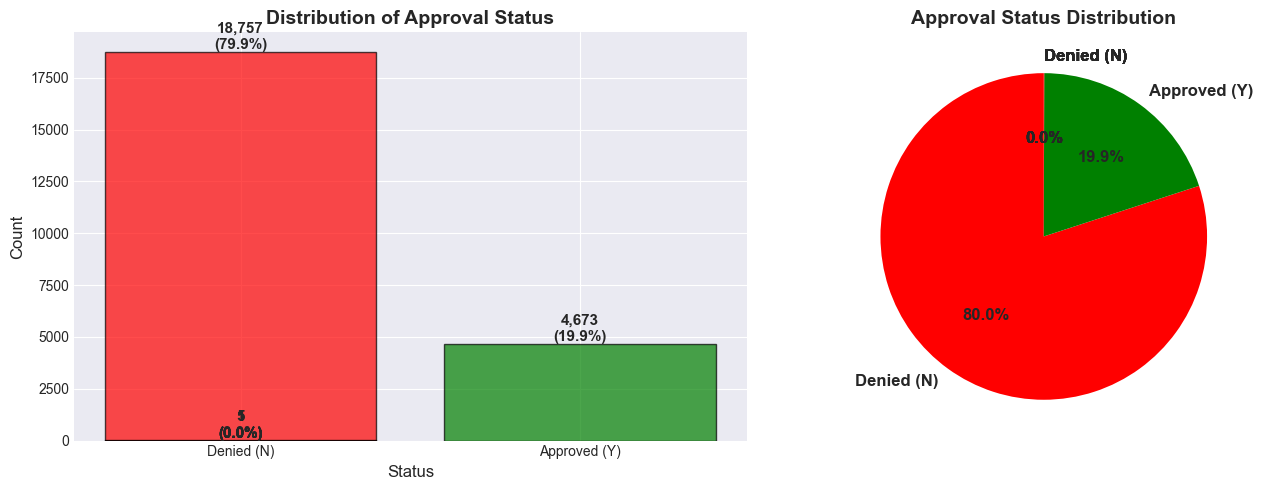

In [ ]:
# Class distribution analysis
print("=" * 60)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 60)

# Count Y and N
status_counts = df['status'].value_counts()
print("\nOriginal class distribution:")
print(status_counts)
print(f"\nPercentages:")
for status, count in status_counts.items():
    pct = (count / len(df)) * 100
    print(f"  {status}: {count:,} ({pct:.2f}%)")

# Check if classes are imbalanced
majority_class = status_counts.index[0]
minority_class = status_counts.index[1]
imbalance_ratio = status_counts.iloc[0] / status_counts.iloc[1]

print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1 ({majority_class}:{minority_class})")

if imbalance_ratio > 1.5:
    print("WARNING: Classes are imbalanced - this may affect model performance")
    print("Consider using class_weight='balanced' in models or sampling techniques")
else:
    print("SUCCESS: Classes are reasonably balanced")

# Visualize distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
# Create labels based on actual status values in the data
bar_labels = ['Approved (Y)' if s == 'Y' else 'Denied (N)' for s in status_counts.index]
colors = ['green' if s == 'Y' else 'red' for s in status_counts.index]
bars = ax1.bar(bar_labels, status_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Status', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of Approval Status', fontsize=14, fontweight='bold')

# Add count labels on bars
for bar, count in zip(bars, status_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({count/len(df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
ax2 = axes[1]
# Use same labels and colors as bar chart
ax2.pie(status_counts.values, labels=bar_labels, colors=colors, autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Approval Status Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)

TARGET VARIABLE ANALYSIS

Status distribution:
status
N         18757
Y          4673
NaN          22
M             5
1             1
REMOVE        1
?             1
H             1
R             1
T             1
Name: count, dtype: int64

Percentage approved: 19.92%
Percentage denied: 79.94%


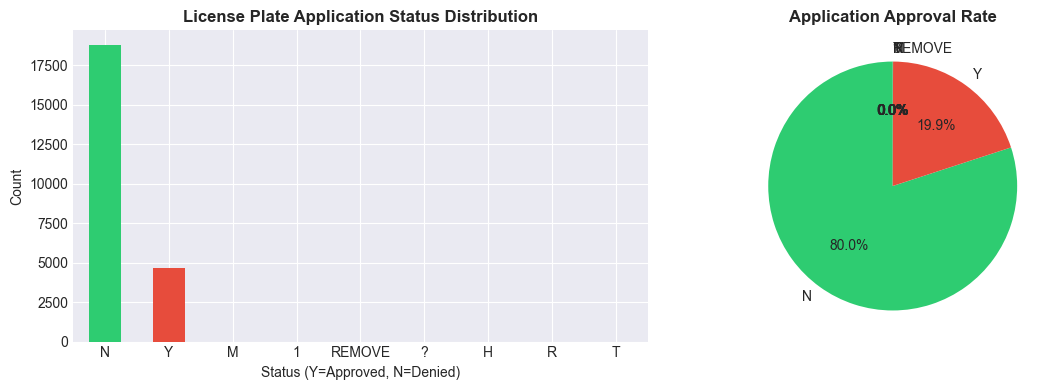

In [ ]:
# Target variable analysis
print("=" * 60)
print("TARGET VARIABLE ANALYSIS")
print("=" * 60)

print("\nStatus distribution:")
status_counts = df['status'].value_counts(dropna=False)
print(status_counts)
print(f"\nPercentage approved: {(status_counts.get('Y', 0) / len(df) * 100):.2f}%")
print(f"Percentage denied: {(status_counts.get('N', 0) / len(df) * 100):.2f}%")

# Visualize status distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
df['status'].value_counts().plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c'])
ax[0].set_title('License Plate Application Status Distribution', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Status (Y=Approved, N=Denied)')
ax[0].set_ylabel('Count')
ax[0].tick_params(axis='x', rotation=0)

# Pie chart
df['status'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                  colors=['#2ecc71', '#e74c3c'], startangle=90)
ax[1].set_title('Application Approval Rate', fontsize=12, fontweight='bold')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

REVIEW REASON CODE ANALYSIS

Review reason code distribution:
review_reason_code
2         9939
1         4639
3         3166
NaN       2044
7         1199
7D         643
5          456
6          427
D          385
4          207
D7          87
7d          63
1 OR 2      19
8           16
7B          15
d7          13
?           11
1, 2        11
1 OR 3       9
B            8
Name: count, dtype: int64


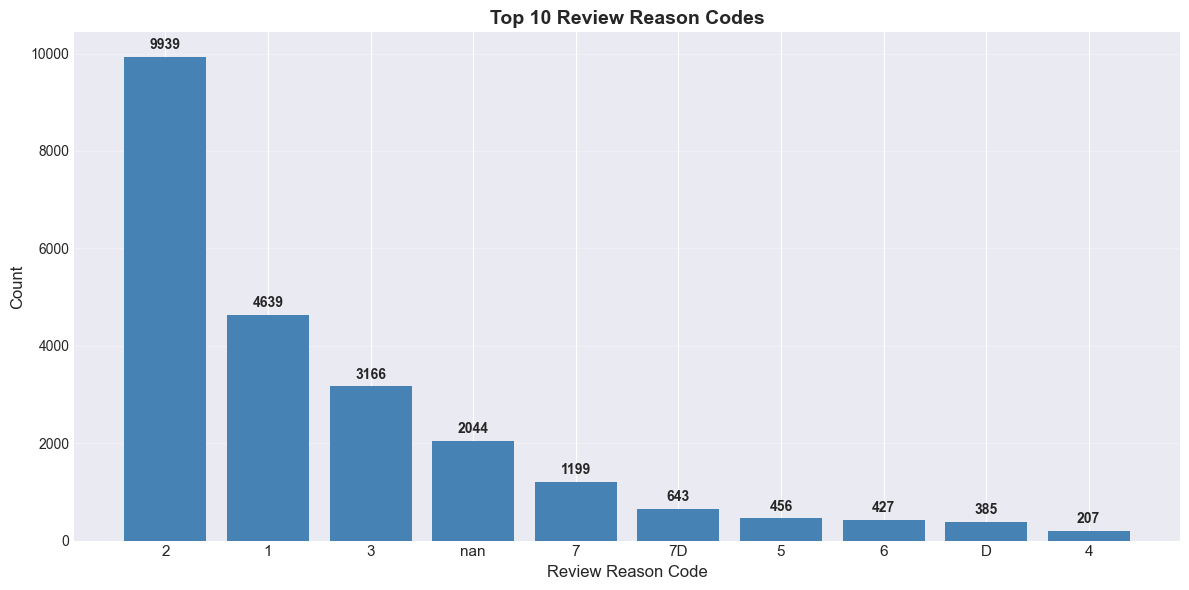


Reason code distribution by approval status (top 10 codes):
status              1  ?  H  M     N  R  REMOVE     Y
review_reason_code                                   
1                   0  0  0  1  3652  0       0   981
2                   1  0  0  2  7773  0       1  2153
3                   0  0  1  2  2826  1       0   334
4                   0  0  0  0   142  0       0    64
5                   0  0  0  0   344  0       0   112
6                   0  0  0  0   327  0       0   100
7                   0  1  0  0  1042  0       0   156
7D                  0  0  0  0   475  0       0   168
D                   0  0  0  0   305  0       0    80

Approval rate by reason code (top 10):
review_reason_code
4     31.07
7D    26.13
5     24.56
6     23.42
2     21.69
1     21.17
D     20.78
7     13.02
3     10.57
dtype: float64


In [ ]:
# Review reason code analysis
print("=" * 60)
print("REVIEW REASON CODE ANALYSIS")
print("=" * 60)

print("\nReview reason code distribution:")
reason_counts = df['review_reason_code'].value_counts(dropna=False)
print(reason_counts.head(20))

# Visualize top reason codes
plt.figure(figsize=(12, 6))
top_n = 10
top_reasons = reason_counts.head(top_n)
bars = plt.bar(range(len(top_reasons)), top_reasons.values, color='steelblue')
plt.xticks(range(len(top_reasons)), top_reasons.index, rotation=0, ha='center', fontsize=11)
plt.title(f'Top {top_n} Review Reason Codes', fontsize=14, fontweight='bold')
plt.xlabel('Review Reason Code', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (idx, val) in enumerate(top_reasons.items()):
    plt.text(i, val + 100, str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Analyze reason codes by status
print("\nReason code distribution by approval status (top 10 codes):")
top_reason_codes = reason_counts.head(10).index
reason_by_status = pd.crosstab(
    df[df['review_reason_code'].isin(top_reason_codes)]['review_reason_code'], 
    df[df['review_reason_code'].isin(top_reason_codes)]['status']
)
print(reason_by_status)

# Calculate approval rate by reason code
print("\nApproval rate by reason code (top 10):")
approval_rates = (reason_by_status['Y'] / (reason_by_status['N'] + reason_by_status['Y']) * 100).sort_values(ascending=False)
print(approval_rates.round(2))

PLATE TEXT ANALYSIS

Plate length statistics:
          count      mean       std  min  25%  50%  75%   max
status                                                       
1           1.0  7.000000       NaN  7.0  7.0  7.0  7.0   7.0
?           1.0  7.000000       NaN  7.0  7.0  7.0  7.0   7.0
H           1.0  6.000000       NaN  6.0  6.0  6.0  6.0   6.0
M           5.0  6.200000  1.303840  4.0  6.0  7.0  7.0   7.0
N       18757.0  6.932718  0.855249  2.0  7.0  7.0  7.0  10.0
R           1.0  7.000000       NaN  7.0  7.0  7.0  7.0   7.0
REMOVE      1.0  7.000000       NaN  7.0  7.0  7.0  7.0   7.0
T           1.0  8.000000       NaN  8.0  8.0  8.0  8.0   8.0
Y        4673.0  6.888508  0.873765  3.0  7.0  7.0  7.0  10.0

Special characteristics by status:
status                                 1  ?  H  M      N  R  REMOVE  T     Y  \
has_special_char has_number has_space                                          
False            False      False      0  0  0  3   5662  1       0  0  1665

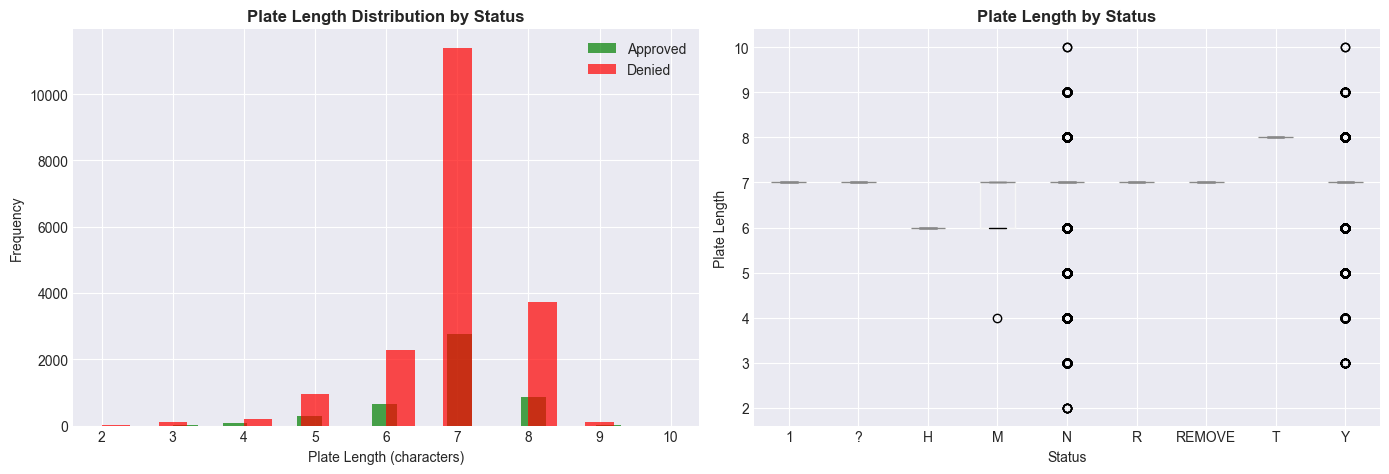

In [ ]:
# Plate text analysis
print("=" * 60)
print("PLATE TEXT ANALYSIS")
print("=" * 60)

# Plate length distribution
df['plate_length'] = df['plate'].fillna('').astype(str).str.len()

print("\nPlate length statistics:")
print(df.groupby('status')['plate_length'].describe())

# Special character analysis
df['has_special_char'] = df['plate'].fillna('').astype(str).str.contains('[#$+&]')
df['has_number'] = df['plate'].fillna('').astype(str).str.contains('[0-9]')
df['has_space'] = df['plate'].fillna('').astype(str).str.contains(' ')

print("\nSpecial characteristics by status:")
print(pd.crosstab([df['has_special_char'], df['has_number'], df['has_space']], 
                   df['status'], margins=True))

# Visualize plate length distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

df[df['status']=='Y']['plate_length'].hist(bins=20, ax=ax[0], color='green', alpha=0.7, label='Approved')
df[df['status']=='N']['plate_length'].hist(bins=20, ax=ax[0], color='red', alpha=0.7, label='Denied')
ax[0].set_title('Plate Length Distribution by Status', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Plate Length (characters)')
ax[0].set_ylabel('Frequency')
ax[0].legend()

df.boxplot(column='plate_length', by='status', ax=ax[1])
ax[1].set_title('Plate Length by Status', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Status')
ax[1].set_ylabel('Plate Length')

plt.suptitle('')
plt.tight_layout()
plt.show()

In [ ]:
# Analyze customer meanings and reviewer comments
print("=" * 60)
print("TEXT FIELD ANALYSIS")
print("=" * 60)

# Text length analysis
df['meaning_length'] = df['customer_meaning'].fillna('').astype(str).str.len()
df['comment_length'] = df['reviewer_comments'].fillna('').astype(str).str.len()

print("\nCustomer meaning length by status:")
print(df.groupby('status')['meaning_length'].describe())

print("\nReviewer comment length by status:")
print(df.groupby('status')['comment_length'].describe())

# Common words in denied applications
from collections import Counter
import string

def get_top_words(text_series, n=20):
    all_words = ' '.join(text_series.fillna('').astype(str).str.lower().values).split()
    # Remove punctuation
    all_words = [word.strip(string.punctuation) for word in all_words if len(word.strip(string.punctuation)) > 2]
    return Counter(all_words).most_common(n)

print("\nTop 20 words in reviewer comments for denied applications:")
denied_comments = df[df['status']=='N']['reviewer_comments']
top_denied_words = get_top_words(denied_comments, 20)
for word, count in top_denied_words:
    print(f"{word:20s}: {count:4d}")

TEXT FIELD ANALYSIS

Customer meaning length by status:
          count       mean        std   min   25%   50%   75%    max
status                                                              
1           1.0  11.000000        NaN  11.0  11.0  11.0  11.0   11.0
?           1.0   8.000000        NaN   8.0   8.0   8.0   8.0    8.0
H           1.0  81.000000        NaN  81.0  81.0  81.0  81.0   81.0
M           5.0  21.200000  21.844908   0.0  14.0  14.0  20.0   58.0
N       18757.0  29.178440  29.048134   0.0  10.0  20.0  39.0  190.0
R           1.0  41.000000        NaN  41.0  41.0  41.0  41.0   41.0
REMOVE      1.0   9.000000        NaN   9.0   9.0   9.0   9.0    9.0
T           1.0  26.000000        NaN  26.0  26.0  26.0  26.0   26.0
Y        4673.0  28.200086  27.118224   0.0  11.0  19.0  37.0  178.0

Reviewer comment length by status:
          count        mean        std    min    25%    50%    75%    max
status                                                                   
1

In [ ]:
# Data preprocessing and cleaning
print("=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# Create a clean dataset
df_clean = df.copy()

# Remove rows with missing status
print(f"\nRows before removing missing status: {len(df_clean)}")
df_clean = df_clean[df_clean['status'].isin(['Y', 'N'])]
print(f"Rows after removing missing status: {len(df_clean)}")

# Fill missing text fields with empty string
text_columns = ['plate', 'customer_meaning', 'reviewer_comments']
for col in text_columns:
    df_clean[col] = df_clean[col].fillna('').astype(str)

# Convert status to binary
df_clean['status_binary'] = (df_clean['status'] == 'Y').astype(int)

# For reason code prediction, filter only denied applications
df_denied = df_clean[df_clean['status'] == 'N'].copy()
df_denied = df_denied[df_denied['review_reason_code'].notna()]
print(f"\nDenied applications with reason codes: {len(df_denied)}")
print(f"Reason code distribution in denied applications:")
print(df_denied['review_reason_code'].value_counts())

print("\nPreprocessing complete!")

DATA PREPROCESSING

Rows before removing missing status: 23463
Rows after removing missing status: 23430

Denied applications with reason codes: 17162
Reason code distribution in denied applications:
review_reason_code
2              7773
1              3652
3              2826
7              1042
7D              475
               ... 
7D?               1
2, 4, OR 7D       1
2 OR 7D           1
2 OR 6            1
10                1
Name: count, Length: 70, dtype: int64

Preprocessing complete!


In [ ]:
# Feature Engineering
print("=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

def create_features(df):
    """Create features from the dataframe"""
    features = pd.DataFrame()
    
    # Text length features
    features['plate_length'] = df['plate'].str.len()
    features['meaning_length'] = df['customer_meaning'].str.len()
    
    # Character type features
    features['has_number'] = df['plate'].str.contains('[0-9]').astype(int)
    features['has_special'] = df['plate'].str.contains('[#$+&]').astype(int)
    features['has_space'] = df['plate'].str.contains(' ').astype(int)
    features['num_count'] = df['plate'].str.count('[0-9]')
    features['alpha_count'] = df['plate'].str.count('[A-Za-z]')
    
    # Uppercase/lowercase ratio
    features['upper_ratio'] = df['plate'].apply(lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1))
    
    # Reason code (one-hot encoded)
    if 'review_reason_code' in df.columns:
        reason_dummies = pd.get_dummies(df['review_reason_code'], prefix='reason', dummy_na=True)
        features = pd.concat([features, reason_dummies], axis=1)
    
    return features

# Create features for approval prediction
X_meta = create_features(df_clean)
print(f"\nMetadata features shape: {X_meta.shape}")
print(f"Feature names: {X_meta.columns.tolist()}")

# Create TF-IDF features from plate text
tfidf_plate = TfidfVectorizer(max_features=100, ngram_range=(1, 2), 
                               analyzer='char', lowercase=True)
X_plate_tfidf = tfidf_plate.fit_transform(df_clean['plate'])
print(f"\nPlate TF-IDF features shape: {X_plate_tfidf.shape}")

# Create TF-IDF features from customer meaning
tfidf_meaning = TfidfVectorizer(max_features=200, ngram_range=(1, 2), 
                                 stop_words='english', lowercase=True)
X_meaning_tfidf = tfidf_meaning.fit_transform(df_clean['customer_meaning'])
print(f"Meaning TF-IDF features shape: {X_meaning_tfidf.shape}")

# Combine all features
from scipy.sparse import hstack
# Convert metadata to float64 to avoid dtype issues with sparse matrices
X_meta_numeric = X_meta.astype('float64').values
X_combined = hstack([X_plate_tfidf, X_meaning_tfidf, X_meta_numeric])
print(f"\nCombined features shape: {X_combined.shape}")

# Target variable
y = df_clean['status_binary'].values
print(f"Target variable shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

FEATURE ENGINEERING

Metadata features shape: (23430, 84)
Feature names: ['plate_length', 'meaning_length', 'has_number', 'has_special', 'has_space', 'num_count', 'alpha_count', 'upper_ratio', 'reason_1', 'reason_1 OR 2', 'reason_1 OR 3', 'reason_1 or 2', 'reason_1 or 3', 'reason_1 or 3?', 'reason_1, 2', 'reason_1, 3', 'reason_1, 7D', 'reason_1, D', 'reason_1,2', 'reason_1,3', 'reason_10', 'reason_11', 'reason_1?', 'reason_2', 'reason_2 OR 3', 'reason_2 OR 5', 'reason_2 OR 6', 'reason_2 OR 7D', 'reason_2 or 1', 'reason_2 or D?', 'reason_2, 1', 'reason_2, 3', 'reason_2, 4', 'reason_2, 4, OR 7D', 'reason_2, 5', 'reason_2, 7B', 'reason_2, 7b', 'reason_2, D', 'reason_2,3', 'reason_2?', 'reason_3', 'reason_3 OR 2', 'reason_3, 1', 'reason_3, 7B', 'reason_3, D', 'reason_3-', 'reason_3?', 'reason_4', 'reason_4?', 'reason_5', 'reason_5,2', 'reason_5-ish', 'reason_6', 'reason_7', 'reason_7(B)', 'reason_7B', 'reason_7B?', 'reason_7D', 'reason_7D OR 1', 'reason_7D OR 2', 'reason_7D, 3', 'reason_7D

In [ ]:
# Train/validation/test split
print("=" * 60)
print("TRAIN/VALIDATION/TEST SPLIT")
print("=" * 60)

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X_combined, y, test_size=0.15, random_state=42, stratify=y
)

# Second split: separate train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/(1-0.15), random_state=42, stratify=y_temp
)

print(f"\nTrain set size: {X_train.shape[0]} ({X_train.shape[0]/len(y)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(y)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(y)*100:.1f}%)")

from collections import Counter
print(f"\nTrain set class distribution:")
for cls, count in Counter(y_train).items():
    print(f"  {cls}: {count}")
print(f"Validation set class distribution:")
for cls, count in Counter(y_val).items():
    print(f"  {cls}: {count}")
print(f"Test set class distribution:")
for cls, count in Counter(y_test).items():
    print(f"  {cls}: {count}")

TRAIN/VALIDATION/TEST SPLIT

Train set size: 16400 (70.0%)
Validation set size: 3515 (15.0%)
Test set size: 3515 (15.0%)

Train set class distribution:
  0: 13129
  1: 3271
Validation set class distribution:
  0: 2814
  1: 701
Test set class distribution:
  0: 2814
  1: 701


In [ ]:
# Baseline Model 1: Majority Class Predictor
print("=" * 60)
print("BASELINE 1: MAJORITY CLASS PREDICTOR")
print("=" * 60)

# Find the majority class from training data
from collections import Counter

# Safety check
if len(y_train) == 0:
    print("\nWARNING: y_train is empty!")
    print("Please make sure the train/test split and balancing cells ran successfully.")
    print(f"y_train length: {len(y_train)}")
    print(f"y_train type: {type(y_train)}")
else:
    train_counts = Counter(y_train)

    print(f"\nTraining set class distribution:")
    for cls, count in train_counts.items():
        pct = (count / len(y_train)) * 100
        print(f"  {cls}: {count:,} ({pct:.1f}%)")

    if len(train_counts) == 0:
        print("\nWARNING: No classes found in training data!")
    else:
        majority_class = train_counts.most_common(1)[0][0]
        print(f"\nMajority class: '{majority_class}'")

        # Predict the majority class for all test samples
        y_pred_majority = np.full(len(y_test), majority_class)

        acc_majority = accuracy_score(y_test, y_pred_majority)
        print(f"\nTest accuracy: {acc_majority:.4f}")
        print("\nThis baseline simply predicts the most common class for all samples.")

BASELINE 1: MAJORITY CLASS PREDICTOR

Training set class distribution:
  0: 13,129 (80.1%)
  1: 3,271 (19.9%)

Majority class: '0'

Test accuracy: 0.8006

This baseline simply predicts the most common class for all samples.


In [ ]:
# Baseline Model 2: Logistic Regression
print("=" * 60)
print("BASELINE 2: LOGISTIC REGRESSION")
print("=" * 60)

# Train logistic regression
lr_model = LogisticRegression(max_iter=1000, random_state=42, C=1.0, class_weight="balanced")
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_val = lr_model.predict(X_val)
y_pred_lr_test = lr_model.predict(X_test)

# Probability predictions for AUC
y_prob_lr_test = lr_model.predict_proba(X_test)[:, 1]

# Evaluate
acc_lr_train = accuracy_score(y_train, y_pred_lr_train)
acc_lr_val = accuracy_score(y_val, y_pred_lr_val)
acc_lr_test = accuracy_score(y_test, y_pred_lr_test)
auc_lr_test = roc_auc_score(y_test, y_prob_lr_test)

print(f"\nTrain accuracy: {acc_lr_train:.4f}")
print(f"Validation accuracy: {acc_lr_val:.4f}")
print(f"Test accuracy: {acc_lr_test:.4f}")
print(f"Test AUC-ROC: {auc_lr_test:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_lr_test, 
                           target_names=['Denied', 'Approved']))

BASELINE 2: LOGISTIC REGRESSION

Train accuracy: 0.6901
Validation accuracy: 0.6595
Test accuracy: 0.6683
Test AUC-ROC: 0.7147

Classification Report (Test Set):
              precision    recall  f1-score   support

      Denied       0.88      0.68      0.77      2814
    Approved       0.32      0.61      0.42       701

    accuracy                           0.67      3515
   macro avg       0.60      0.65      0.60      3515
weighted avg       0.77      0.67      0.70      3515



In [ ]:
# Model 3: Random Forest
print("=" * 60)
print("MODEL 3: RANDOM FOREST")
print("=" * 60)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", max_depth=20, 
                                  random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_val = rf_model.predict(X_val)
y_pred_rf_test = rf_model.predict(X_test)
y_prob_rf_test = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
acc_rf_train = accuracy_score(y_train, y_pred_rf_train)
acc_rf_val = accuracy_score(y_val, y_pred_rf_val)
acc_rf_test = accuracy_score(y_test, y_pred_rf_test)
auc_rf_test = roc_auc_score(y_test, y_prob_rf_test)

print(f"\nTrain accuracy: {acc_rf_train:.4f}")
print(f"Validation accuracy: {acc_rf_val:.4f}")
print(f"Test accuracy: {acc_rf_test:.4f}")
print(f"Test AUC-ROC: {auc_rf_test:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_rf_test, 
                           target_names=['Denied', 'Approved']))

MODEL 3: RANDOM FOREST

Train accuracy: 0.9435
Validation accuracy: 0.7977
Test accuracy: 0.7949
Test AUC-ROC: 0.7137

Classification Report (Test Set):
              precision    recall  f1-score   support

      Denied       0.84      0.91      0.88      2814
    Approved       0.48      0.32      0.39       701

    accuracy                           0.79      3515
   macro avg       0.66      0.62      0.63      3515
weighted avg       0.77      0.79      0.78      3515



In [ ]:
# Model 4: Gradient Boosting
print("=" * 60)
print("MODEL 4: GRADIENT BOOSTING")
print("=" * 60)

# Train Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                      max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb_train = gb_model.predict(X_train)
y_pred_gb_val = gb_model.predict(X_val)
y_pred_gb_test = gb_model.predict(X_test)
y_prob_gb_test = gb_model.predict_proba(X_test)[:, 1]

# Evaluate
acc_gb_train = accuracy_score(y_train, y_pred_gb_train)
acc_gb_val = accuracy_score(y_val, y_pred_gb_val)
acc_gb_test = accuracy_score(y_test, y_pred_gb_test)
auc_gb_test = roc_auc_score(y_test, y_prob_gb_test)

print(f"\nTrain accuracy: {acc_gb_train:.4f}")
print(f"Validation accuracy: {acc_gb_val:.4f}")
print(f"Test accuracy: {acc_gb_test:.4f}")
print(f"Test AUC-ROC: {auc_gb_test:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_gb_test, 
                           target_names=['Denied', 'Approved']))

MODEL 4: GRADIENT BOOSTING

Train accuracy: 0.8427
Validation accuracy: 0.8179
Test accuracy: 0.8165
Test AUC-ROC: 0.7055

Classification Report (Test Set):
              precision    recall  f1-score   support

      Denied       0.82      0.98      0.90      2814
    Approved       0.67      0.16      0.25       701

    accuracy                           0.82      3515
   macro avg       0.75      0.57      0.57      3515
weighted avg       0.79      0.82      0.77      3515



In [ ]:
# Model 5: Voting Classifier (Ensemble)
print("=" * 60)
print("MODEL 5: VOTING CLASSIFIER (SOFT VOTING ENSEMBLE)")
print("=" * 60)

# Create voting classifier with best performing models
estimators = [
    ('lr', lr_model),
    ('rf', rf_model),
    ('gb', gb_model)
]

# Add XGBoost and LightGBM if available and trained
if XGBOOST_AVAILABLE:
    try:
        # Check if xgb_model exists
        xgb_model
        estimators.append(('xgb', xgb_model))
    except NameError:
        print("Note: XGBoost model not trained yet, skipping from ensemble")
        
if LIGHTGBM_AVAILABLE:
    try:
        # Check if lgb_model exists
        lgb_model
        estimators.append(('lgb', lgb_model))
    except NameError:
        print("Note: LightGBM model not trained yet, skipping from ensemble")

voting_model = VotingClassifier(
    estimators=estimators,
    voting='soft'
)

print(f"\nEnsemble contains {len(estimators)} models: {[name for name, _ in estimators]}")
print("Training voting classifier...")
voting_model.fit(X_train, y_train)

# Predictions
y_pred_voting_test = voting_model.predict(X_test)
y_prob_voting_test = voting_model.predict_proba(X_test)[:, 1]

# Evaluate
acc_voting_test = accuracy_score(y_test, y_pred_voting_test)
auc_voting_test = roc_auc_score(y_test, y_prob_voting_test)

print(f"\nTest accuracy: {acc_voting_test:.4f}")
print(f"Test AUC-ROC: {auc_voting_test:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_voting_test, 
                           target_names=['Denied', 'Approved']))

MODEL 7: VOTING CLASSIFIER (SOFT VOTING ENSEMBLE)
Note: XGBoost model not trained yet, skipping from ensemble
Note: LightGBM model not trained yet, skipping from ensemble

Ensemble contains 3 models: ['lr', 'rf', 'gb']
Training voting classifier...

Test accuracy: 0.8111
Test AUC-ROC: 0.7272

Classification Report (Test Set):
              precision    recall  f1-score   support

      Denied       0.84      0.95      0.89      2814
    Approved       0.56      0.27      0.36       701

    accuracy                           0.81      3515
   macro avg       0.70      0.61      0.62      3515
weighted avg       0.78      0.81      0.78      3515



In [ ]:
# Model 6: XGBoost (if available)
if XGBOOST_AVAILABLE:
    print("=" * 60)
    print("MODEL 6: XGBOOST")
    print("=" * 60)
    
    # Train XGBoost
    # Calculate scale_pos_weight for imbalanced classes
    from collections import Counter
    counts = Counter(y_train)
    scale_pos_weight = counts[list(counts.keys())[0]] / counts[list(counts.keys())[1]]

    xgb_model = xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        
        n_estimators=150,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_xgb_train = xgb_model.predict(X_train)
    y_pred_xgb_val = xgb_model.predict(X_val)
    y_pred_xgb_test = xgb_model.predict(X_test)
    y_prob_xgb_test = xgb_model.predict_proba(X_test)[:, 1]
    
    # Evaluate
    acc_xgb_train = accuracy_score(y_train, y_pred_xgb_train)
    acc_xgb_val = accuracy_score(y_val, y_pred_xgb_val)
    acc_xgb_test = accuracy_score(y_test, y_pred_xgb_test)
    auc_xgb_test = roc_auc_score(y_test, y_prob_xgb_test)
    
    print(f"\nTrain accuracy: {acc_xgb_train:.4f}")
    print(f"Validation accuracy: {acc_xgb_val:.4f}")
    print(f"Test accuracy: {acc_xgb_test:.4f}")
    print(f"Test AUC-ROC: {auc_xgb_test:.4f}")
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_xgb_test, 
                               target_names=['Denied', 'Approved']))
else:
    print("XGBoost not available. Install with: pip install xgboost")
    acc_xgb_test = 0
    auc_xgb_test = 0
    y_pred_xgb_test = None
    y_prob_xgb_test = None

MODEL 5: XGBOOST


In [ ]:
# Direct Model Accuracy Comparison
print("=" * 80)
print("DIRECT MODEL ACCURACY COMPARISON")
print("=" * 80)

# Collect all model accuracies
model_accuracies = {
    'Logistic Regression': {
        'Train': acc_lr_train,
        'Validation': acc_lr_val,
        'Test': acc_lr_test,
        'AUC': auc_lr_test
    },
    'Random Forest': {
        'Train': acc_rf_train,
        'Validation': acc_rf_val,
        'Test': acc_rf_test,
        'AUC': auc_rf_test
    },
    'Gradient Boosting': {
        'Train': acc_gb_train,
        'Validation': acc_gb_val,
        'Test': acc_gb_test,
        'AUC': auc_gb_test
    }
}

# Add XGBoost and LightGBM if available
if XGBOOST_AVAILABLE:
    try:
        model_accuracies['XGBoost'] = {
            'Train': acc_xgb_train,
            'Validation': acc_xgb_val,
            'Test': acc_xgb_test,
            'AUC': auc_xgb_test
        }
    except NameError:
        pass

if LIGHTGBM_AVAILABLE:
    try:
        model_accuracies['LightGBM'] = {
            'Train': acc_lgb_train,
            'Validation': acc_lgb_val,
            'Test': acc_lgb_test,
            'AUC': auc_lgb_test
        }
    except NameError:
        pass

# Add ensemble models if they were trained
try:
    if acc_voting_test > 0:
        model_accuracies['Voting Ensemble'] = {
            'Train': None,
            'Validation': None,
            'Test': acc_voting_test,
            'AUC': auc_voting_test
        }
except NameError:
    print("Note: Voting Ensemble not yet trained, skipping from comparison")

try:
    if acc_stacking_test > 0:
        model_accuracies['Stacking Ensemble'] = {
            'Train': None,
            'Validation': None,
            'Test': acc_stacking_test,
            'AUC': auc_stacking_test
        }
except NameError:
    print("Note: Stacking Ensemble not yet trained, skipping from comparison")

# Create comparison DataFrame
comparison_data = []
for model, scores in model_accuracies.items():
    comparison_data.append({
        'Model': model,
        'Train Accuracy': scores['Train'] if scores['Train'] else '-',
        'Val Accuracy': scores['Validation'] if scores['Validation'] else '-',
        'Test Accuracy': scores['Test'],
        'Test AUC-ROC': scores['AUC']
    })

accuracy_comparison_df = pd.DataFrame(comparison_data)

# Sort by test accuracy
accuracy_comparison_df_sorted = accuracy_comparison_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print("\nRESULTS: MODEL ACCURACY COMPARISON TABLE")
print("-" * 80)
print(accuracy_comparison_df_sorted.to_string(index=False))

# Find the best model
best_model_row = accuracy_comparison_df_sorted.iloc[0]
print("\n" + "=" * 80)
print("BEST MODEL: BEST MODEL IDENTIFIED")
print("=" * 80)
print(f"Model Name:       {best_model_row['Model']}")
print(f"Test Accuracy:    {best_model_row['Test Accuracy']:.4f}")
print(f"Test AUC-ROC:     {best_model_row['Test AUC-ROC']:.4f}")

# Calculate improvement over baseline and other models
baseline_acc = acc_majority
improvement_vs_baseline = (best_model_row['Test Accuracy'] - baseline_acc) * 100
print(f"\nImprovement over baseline: +{improvement_vs_baseline:.2f}% (absolute)")

# Compare to second best
if len(accuracy_comparison_df_sorted) > 1:
    second_best = accuracy_comparison_df_sorted.iloc[1]
    improvement_vs_second = (best_model_row['Test Accuracy'] - second_best['Test Accuracy']) * 100
    print(f"Better than 2nd place ({second_best['Model']}): +{improvement_vs_second:.2f}% (absolute)")

# Check for overfitting
if best_model_row['Train Accuracy'] != '-':
    train_test_gap = best_model_row['Train Accuracy'] - best_model_row['Test Accuracy']
    print(f"\nTrain-Test Gap:   {train_test_gap:.4f}")
    if train_test_gap > 0.05:
        print("WARNING: Warning: Moderate overfitting detected")
    elif train_test_gap > 0.10:
        print("ALERT: Alert: Significant overfitting detected")
    else:
        print("SUCCESS: Model generalizes well")

print("=" * 80)

In [ ]:
# Visual Accuracy Ranking
print("=" * 80)
print("VISUAL MODEL RANKING")
print("=" * 80)

# Create side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Test Accuracy Ranking
ax1 = axes[0]
colors_acc = ['gold' if i == 0 else 'silver' if i == 1 else 'sandybrown' if i == 2 else 'steelblue' 
              for i in range(len(accuracy_comparison_df_sorted))]
bars1 = ax1.barh(range(len(accuracy_comparison_df_sorted)), 
                 accuracy_comparison_df_sorted['Test Accuracy'], 
                 color=colors_acc)
ax1.set_yticks(range(len(accuracy_comparison_df_sorted)))
ax1.set_yticklabels(accuracy_comparison_df_sorted['Model'])
ax1.set_xlabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('BEST MODEL: Test Accuracy Ranking', fontsize=14, fontweight='bold')
ax1.set_xlim([0.75, 0.90])
ax1.axvline(x=acc_majority, color='red', linestyle='--', linewidth=2, label='Baseline', alpha=0.7)
ax1.legend(loc='lower right')
ax1.grid(axis='x', alpha=0.3)

# Add accuracy values on bars
for i, (idx, row) in enumerate(accuracy_comparison_df_sorted.iterrows()):
    ax1.text(row['Test Accuracy'] + 0.002, i, f"{row['Test Accuracy']:.4f}", 
             va='center', fontsize=9, fontweight='bold')

# 2. AUC-ROC Ranking
ax2 = axes[1]
auc_sorted = accuracy_comparison_df_sorted.sort_values('Test AUC-ROC', ascending=False).reset_index(drop=True)
colors_auc = ['gold' if i == 0 else 'silver' if i == 1 else 'sandybrown' if i == 2 else 'coral' 
              for i in range(len(auc_sorted))]
bars2 = ax2.barh(range(len(auc_sorted)), auc_sorted['Test AUC-ROC'], color=colors_auc)
ax2.set_yticks(range(len(auc_sorted)))
ax2.set_yticklabels(auc_sorted['Model'])
ax2.set_xlabel('Test AUC-ROC', fontsize=12, fontweight='bold')
ax2.set_title(' AUC-ROC Ranking', fontsize=14, fontweight='bold')
ax2.set_xlim([0.65, 0.85])
ax2.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Random', alpha=0.7)
ax2.legend(loc='lower right')
ax2.grid(axis='x', alpha=0.3)

# Add AUC values on bars
for i, (idx, row) in enumerate(auc_sorted.iterrows()):
    ax2.text(row['Test AUC-ROC'] + 0.005, i, f"{row['Test AUC-ROC']:.4f}", 
             va='center', fontsize=9, fontweight='bold')

# 3. Model Comparison: Train vs Test Accuracy
ax3 = axes[2]
train_test_models = [m for m in accuracy_comparison_df_sorted['Model'] 
                     if accuracy_comparison_df_sorted[accuracy_comparison_df_sorted['Model']==m]['Train Accuracy'].values[0] != '-']
train_accs = [accuracy_comparison_df_sorted[accuracy_comparison_df_sorted['Model']==m]['Train Accuracy'].values[0] 
              for m in train_test_models]
test_accs = [accuracy_comparison_df_sorted[accuracy_comparison_df_sorted['Model']==m]['Test Accuracy'].values[0] 
             for m in train_test_models]

x_pos = np.arange(len(train_test_models))
width = 0.35
ax3.bar(x_pos - width/2, train_accs, width, label='Train', alpha=0.8, color='lightgreen')
ax3.bar(x_pos + width/2, test_accs, width, label='Test', alpha=0.8, color='steelblue')
ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax3.set_title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(train_test_models, rotation=45, ha='right')
ax3.legend()
ax3.set_ylim([0.75, 0.90])
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSUCCESS: Visual ranking complete!")
print("\n Key Insights:")
print(f" - Gold bars = 1st place")
print(f" - Silver bars = 2nd place")
print(f" - Bronze bars = 3rd place")
print(f" - Best model: {accuracy_comparison_df_sorted.iloc[0]['Model']}")
print(f" - Highest Test Accuracy: {accuracy_comparison_df_sorted.iloc[0]['Test Accuracy']:.4f}")
print(f" - Highest AUC-ROC: {auc_sorted.iloc[0]['Test AUC-ROC']:.4f} ({auc_sorted.iloc[0]['Model']})")

In [ ]:
# Reason Code Prediction Data Preparation
print("=" * 60)
print("REASON CODE PREDICTION - DATA PREPARATION")
print("=" * 60)

# Filter denied applications with valid reason codes
df_denied_clean = df_clean[df_clean['status'] == 'N'].copy()
df_denied_clean = df_denied_clean[df_denied_clean['review_reason_code'].notna()]

print(f"\nTotal denied applications with reason codes: {len(df_denied_clean)}")
print(f"\nReason code distribution:")
reason_counts = df_denied_clean['review_reason_code'].value_counts()
print(reason_counts.head(20))

# Filter out rare reason codes
min_samples = 10
valid_reasons = reason_counts[reason_counts >= min_samples].index
df_denied_clean = df_denied_clean[df_denied_clean['review_reason_code'].isin(valid_reasons)]

print(f"\nAfter filtering (keeping codes with ≥{min_samples} samples): {len(df_denied_clean)}")
print(f"Number of unique reason codes: {df_denied_clean['review_reason_code'].nunique()}")

# Convert reason codes to numeric labels
reason_encoder = LabelEncoder()
df_denied_clean['reason_label'] = reason_encoder.fit_transform(
    df_denied_clean['review_reason_code']
)

print(f"\nReason code mapping (top codes):")
for i, code in enumerate(reason_encoder.classes_[:15]):
    count = (df_denied_clean['reason_label'] == i).sum()
    print(f"  {code:15s} -> {i:2d} (n={count})")
if len(reason_encoder.classes_) > 15:
    print(f"  ... and {len(reason_encoder.classes_) - 15} more codes")

# Create features for denied applications without reason code as feature
def create_features_no_reason(df):
    """Create features without reason code"""
    features = pd.DataFrame()
    features['plate_length'] = df['plate'].str.len()
    features['meaning_length'] = df['customer_meaning'].str.len()
    features['has_number'] = df['plate'].str.contains('[0-9]').astype(int)
    features['has_special'] = df['plate'].str.contains('[#$+&]').astype(int)
    features['has_space'] = df['plate'].str.contains(' ').astype(int)
    features['num_count'] = df['plate'].str.count('[0-9]')
    features['alpha_count'] = df['plate'].str.count('[A-Za-z]')
    features['upper_ratio'] = df['plate'].apply(
        lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1)
    )
    return features

X_denied_meta = create_features_no_reason(df_denied_clean)
X_denied_plate_tfidf = tfidf_plate.transform(df_denied_clean['plate'])
X_denied_meaning_tfidf = tfidf_meaning.transform(df_denied_clean['customer_meaning'])
# Convert to float64 to avoid dtype issues
X_denied_meta_numeric = X_denied_meta.astype('float64').values
X_denied_combined = hstack([X_denied_plate_tfidf, X_denied_meaning_tfidf, 
                             X_denied_meta_numeric])
y_denied = df_denied_clean['reason_label'].values

print(f"\nDenied applications feature matrix shape: {X_denied_combined.shape}")
print(f"Reason labels shape: {y_denied.shape}")
print(f"Class distribution (should all be ≥{min_samples}): min={np.bincount(y_denied).min()}, max={np.bincount(y_denied).max()}")

REASON CODE PREDICTION - DATA PREPARATION

Total denied applications with reason codes: 17162

Reason code distribution:
review_reason_code
2         7773
1         3652
3         2826
7         1042
7D         475
5          344
6          327
D          305
4          142
D7          68
7d          38
1 OR 2      18
8           13
7B          11
1, 2        11
d7          10
1,2          7
1 OR 3       7
9            6
B            6
Name: count, dtype: int64

After filtering (keeping codes with ≥10 samples): 17055
Number of unique reason codes: 16

Reason code mapping (top codes):
  1               ->  0 (n=3652)
  1 OR 2          ->  1 (n=18)
  1, 2            ->  2 (n=11)
  2               ->  3 (n=7773)
  3               ->  4 (n=2826)
  4               ->  5 (n=142)
  5               ->  6 (n=344)
  6               ->  7 (n=327)
  7               ->  8 (n=1042)
  7B              ->  9 (n=11)
  7D              -> 10 (n=475)
  7d              -> 11 (n=38)
  8               -> 12 (

In [ ]:
# Split denied applications data with fixed stratification
print("Splitting denied applications data...")

X_denied_temp, X_denied_test, y_denied_temp, y_denied_test = train_test_split(
    X_denied_combined, y_denied, test_size=0.15, random_state=42, stratify=y_denied
)

X_denied_train, X_denied_val, y_denied_train, y_denied_val = train_test_split(
    X_denied_temp, y_denied_temp, test_size=0.15/(1-0.15), random_state=42, 
    stratify=y_denied_temp
)

print(f"\nDenied train set: {X_denied_train.shape[0]}")
print(f"Denied validation set: {X_denied_val.shape[0]}")
print(f"Denied test set: {X_denied_test.shape[0]}")
print("SUCCESS: Data split complete!")

Splitting denied applications data...

Denied train set: 11937
Denied validation set: 2559
Denied test set: 2559
✓ Data split complete!


In [ ]:
# Split denied applications data
X_denied_temp, X_denied_test, y_denied_temp, y_denied_test = train_test_split(
    X_denied_combined, y_denied, test_size=0.15, random_state=42, stratify=y_denied
)

X_denied_train, X_denied_val, y_denied_train, y_denied_val = train_test_split(
    X_denied_temp, y_denied_temp, test_size=0.15/(1-0.15), random_state=42, 
    stratify=y_denied_temp
)

print(f"\nDenied train set: {X_denied_train.shape[0]}")
print(f"Denied validation set: {X_denied_val.shape[0]}")
print(f"Denied test set: {X_denied_test.shape[0]}")


Denied train set: 11937
Denied validation set: 2559
Denied test set: 2559


In [ ]:
# Reason Code Model: Random Forest
print("=" * 60)
print("REASON CODE MODEL: RANDOM FOREST")
print("=" * 60)

rf_reason_model = RandomForestClassifier(n_estimators=100, max_depth=20, 
                                         random_state=42, n_jobs=-1)
rf_reason_model.fit(X_denied_train, y_denied_train)

y_reason_pred_rf = rf_reason_model.predict(X_denied_test)
acc_reason_rf = accuracy_score(y_denied_test, y_reason_pred_rf)

print(f"\nTest accuracy: {acc_reason_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_denied_test, y_reason_pred_rf, 
                           target_names=reason_encoder.classes_))

REASON CODE MODEL: RANDOM FOREST

Test accuracy: 0.5873

Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.35      0.44       548
      1 OR 2       0.00      0.00      0.00         3
        1, 2       0.00      0.00      0.00         2
           2       0.57      0.91      0.70      1166
           3       0.66      0.54      0.60       424
           4       0.00      0.00      0.00        21
           5       0.73      0.21      0.33        52
           6       0.88      0.29      0.43        49
           7       0.00      0.00      0.00       156
          7B       0.00      0.00      0.00         2
          7D       0.00      0.00      0.00        71
          7d       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         2
           D       1.00      0.04      0.08        46
          D7       0.00      0.00      0.00        10
          d7       0.00      0.00      0.00         1



In [24]:
# Reason Code Model: Gradient Boosting
print("=" * 60)
print("REASON CODE MODEL: GRADIENT BOOSTING")
print("=" * 60)

gb_reason_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                             max_depth=5, random_state=42)
gb_reason_model.fit(X_denied_train, y_denied_train)

y_reason_pred_gb = gb_reason_model.predict(X_denied_test)
acc_reason_gb = accuracy_score(y_denied_test, y_reason_pred_gb)

print(f"\nTest accuracy: {acc_reason_gb:.4f}")
print("\nClassification Report:")
print(classification_report(y_denied_test, y_reason_pred_gb, 
                           target_names=reason_encoder.classes_))

REASON CODE MODEL: GRADIENT BOOSTING

Test accuracy: 0.5772

Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.42      0.48       548
      1 OR 2       0.00      0.00      0.00         3
        1, 2       0.00      0.00      0.00         2
           2       0.60      0.81      0.69      1166
           3       0.63      0.58      0.60       424
           4       0.12      0.10      0.11        21
           5       0.50      0.37      0.42        52
           6       0.58      0.53      0.55        49
           7       0.22      0.03      0.06       156
          7B       0.00      0.00      0.00         2
          7D       0.14      0.04      0.06        71
          7d       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         2
           D       0.13      0.09      0.11        46
          D7       0.00      0.00      0.00        10
          d7       0.00      0.00      0.00        

MODEL COMPARISON - APPROVAL PREDICTION

               Model  Test Accuracy  Test AUC
     Majority Class       0.800569  0.500000
Logistic Regression       0.668279  0.714737
      Random Forest       0.794879  0.713651
  Gradient Boosting       0.816501  0.705476


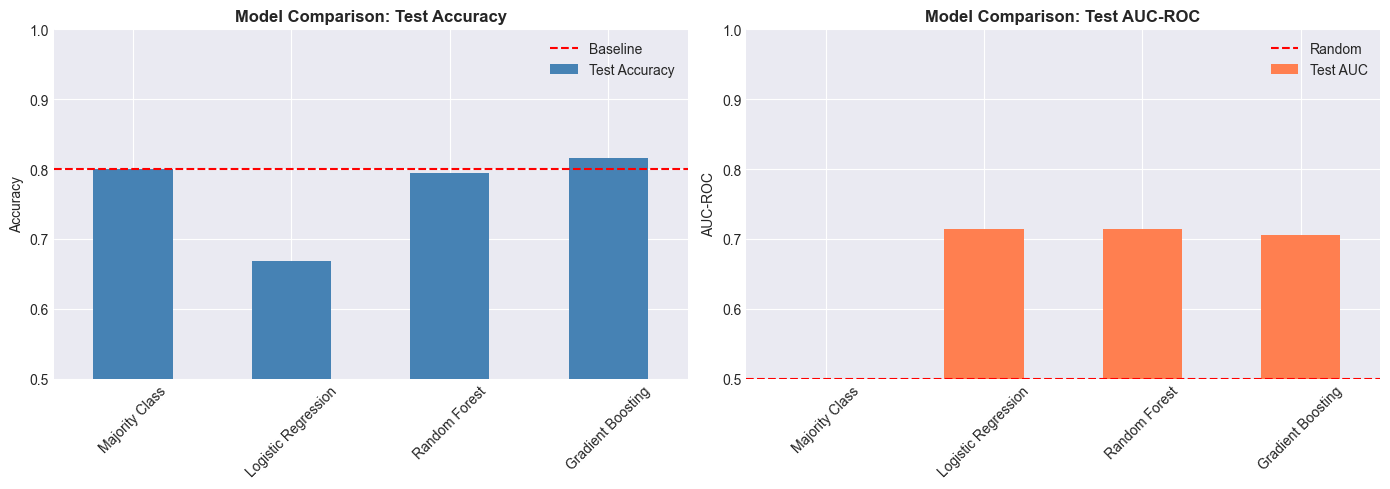

In [ ]:
# Model Comparison Summary
print("=" * 60)
print("MODEL COMPARISON - APPROVAL PREDICTION")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Model': ['Majority Class', 'Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Test Accuracy': [
        acc_majority,
        acc_lr_test,
        acc_rf_test,
        acc_gb_test
    ],
    'Test AUC': [
        0.5,
        auc_lr_test,
        auc_rf_test,
        auc_gb_test
    ]
})

print("\n", comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

comparison_df.plot(x='Model', y='Test Accuracy', kind='bar', ax=ax[0], 
                   legend=False, color='steelblue')
ax[0].set_title('Model Comparison: Test Accuracy', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('')
ax[0].set_ylim([0.5, 1.0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].axhline(y=acc_majority, color='r', linestyle='--', label='Baseline')
ax[0].legend()

comparison_df.plot(x='Model', y='Test AUC', kind='bar', ax=ax[1], 
                   legend=False, color='coral')
ax[1].set_title('Model Comparison: Test AUC-ROC', fontsize=12, fontweight='bold')
ax[1].set_ylabel('AUC-ROC')
ax[1].set_xlabel('')
ax[1].set_ylim([0.5, 1.0])
ax[1].tick_params(axis='x', rotation=45)
ax[1].axhline(y=0.5, color='r', linestyle='--', label='Random')
ax[1].legend()

plt.tight_layout()
plt.show()

MODEL COMPARISON - REASON CODE PREDICTION

             Model  Test Accuracy
    Random Forest       0.587339
Gradient Boosting       0.577179

Best Reason Code Model: Random Forest
Test Accuracy: 0.5873


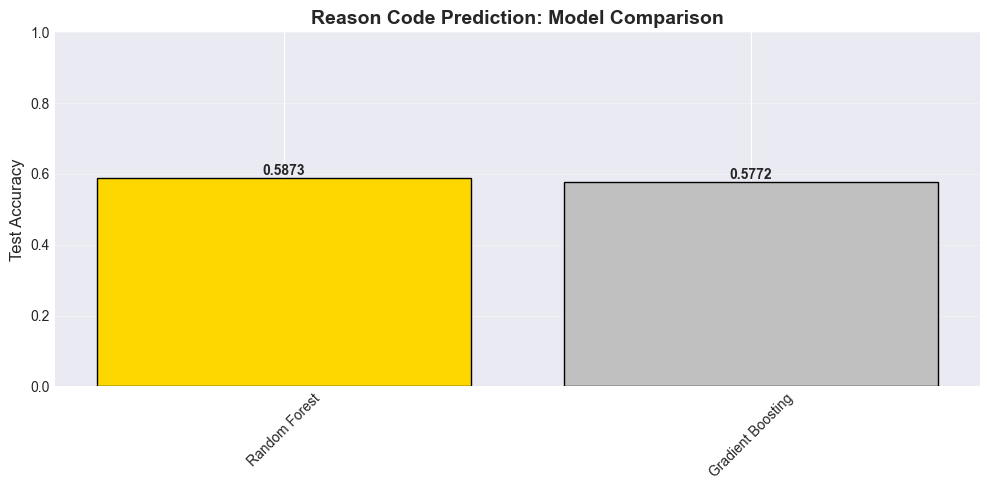

In [26]:
# Model Comparison - Reason Code Prediction
print("=" * 60)
print("MODEL COMPARISON - REASON CODE PREDICTION")
print("=" * 60)

# Collect models that were trained
models_reason = []
accuracies_reason = []

# Add models if they exist
try:
    acc_reason_rf
    models_reason.append('Random Forest')
    accuracies_reason.append(acc_reason_rf)
except NameError:
    pass

try:
    acc_reason_gb
    models_reason.append('Gradient Boosting')
    accuracies_reason.append(acc_reason_gb)
except NameError:
    pass

try:
    acc_reason_lr
    models_reason.append('Logistic Regression')
    accuracies_reason.append(acc_reason_lr)
except NameError:
    pass

if models_reason:
    reason_comparison_df = pd.DataFrame({
        'Model': models_reason,
        'Test Accuracy': accuracies_reason
    })

    # Sort by accuracy
    reason_comparison_df = reason_comparison_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

    print("\n", reason_comparison_df.to_string(index=False))

    # Find best model
    best_reason_model = reason_comparison_df.iloc[0]['Model']
    best_reason_acc = reason_comparison_df.iloc[0]['Test Accuracy']

    print(f"\n{'='*60}")
    print(f"Best Reason Code Model: {best_reason_model}")
    print(f"Test Accuracy: {best_reason_acc:.4f}")
    print(f"{'='*60}")

    # Visualize
    plt.figure(figsize=(10, 5))
    colors = ['gold' if i == 0 else 'silver' if i == 1 else 'steelblue'
              for i in range(len(reason_comparison_df))]
    bars = plt.bar(range(len(reason_comparison_df)),
                   reason_comparison_df['Test Accuracy'],
                   color=colors, edgecolor='black')
    plt.xticks(range(len(reason_comparison_df)), reason_comparison_df['Model'], rotation=45)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Reason Code Prediction: Model Comparison', fontsize=14, fontweight='bold')
    plt.ylim([0, 1])

    # Add accuracy labels on bars
    for bar, acc in zip(bars, reason_comparison_df['Test Accuracy']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo reason code models have been trained yet.")
    print("Please run the reason code model cells first.")

CONFUSION MATRIX - APPROVAL PREDICTION (GRADIENT BOOSTING)


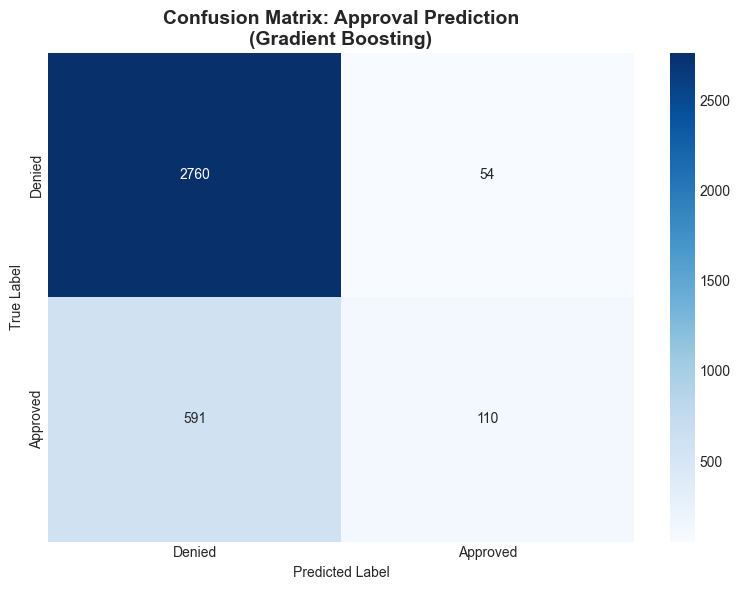


True Negatives (Correctly predicted denied): 2760
False Positives (Incorrectly predicted approved): 54
False Negatives (Incorrectly predicted denied): 591
True Positives (Correctly predicted approved): 110


In [ ]:
# Confusion Matrix - Approval Prediction
print("=" * 60)
print("CONFUSION MATRIX - APPROVAL PREDICTION (GRADIENT BOOSTING)")
print("=" * 60)

cm = confusion_matrix(y_test, y_pred_gb_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Denied', 'Approved'],
            yticklabels=['Denied', 'Approved'])
plt.title('Confusion Matrix: Approval Prediction\n(Gradient Boosting)', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

CONFUSION MATRIX - REASON CODE PREDICTION (GRADIENT BOOSTING)


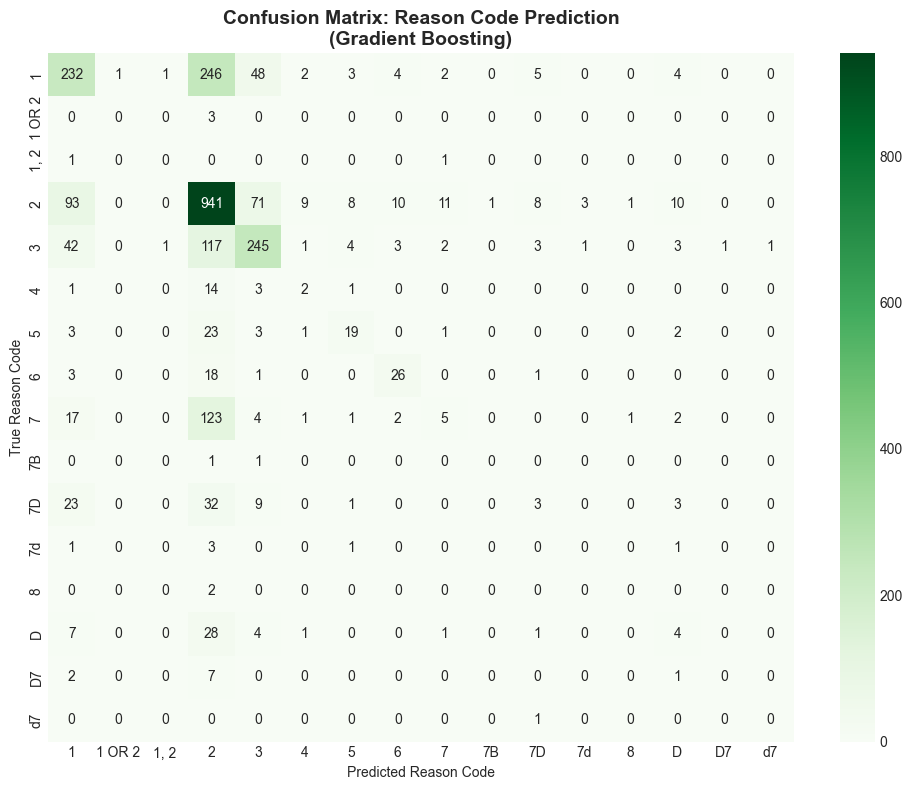

In [ ]:
# Confusion Matrix - Reason Code Prediction
print("=" * 60)
print("CONFUSION MATRIX - REASON CODE PREDICTION (GRADIENT BOOSTING)")
print("=" * 60)

cm_reason = confusion_matrix(y_denied_test, y_reason_pred_gb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_reason, annot=True, fmt='d', cmap='Greens',
            xticklabels=reason_encoder.classes_,
            yticklabels=reason_encoder.classes_)
plt.title('Confusion Matrix: Reason Code Prediction\n(Gradient Boosting)', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Reason Code')
plt.xlabel('Predicted Reason Code')
plt.tight_layout()
plt.show()

ROC CURVES - APPROVAL PREDICTION


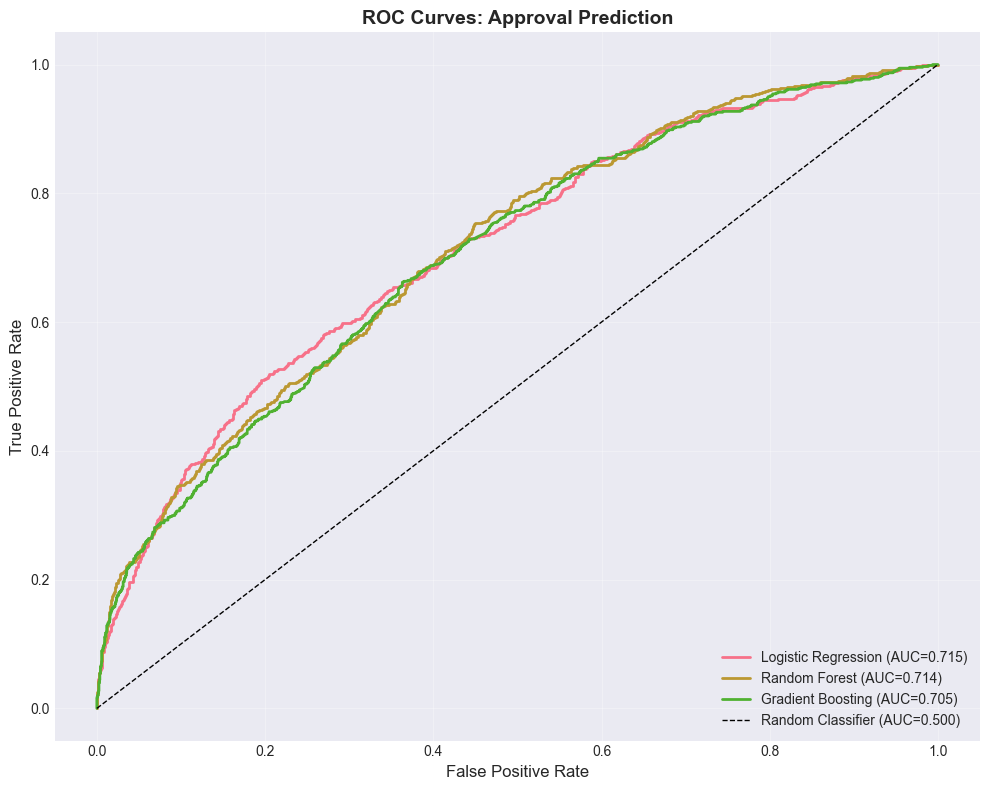

In [29]:
# ROC Curve - Approval Prediction
print("=" * 60)
print("ROC CURVES - APPROVAL PREDICTION")
print("=" * 60)

# Calculate ROC curves for each model
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf_test)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb_test)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr_test:.3f})', 
         linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf_test:.3f})', 
         linewidth=2)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC={auc_gb_test:.3f})', 
         linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC=0.500)', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Approval Prediction', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features (Random Forest):
 1. plate_tfidf_64                          : 0.026800
 2. meaning_length                          : 0.025823
 3. reason_3                                : 0.025572
 4. plate_tfidf_59                          : 0.024629
 5. plate_tfidf_17                          : 0.023737
 6. plate_tfidf_41                          : 0.019919
 7. plate_tfidf_81                          : 0.019854
 8. plate_tfidf_31                          : 0.019126
 9. upper_ratio                             : 0.018835
10. plate_tfidf_43                          : 0.018475
11. plate_tfidf_0                           : 0.017758
12. plate_tfidf_46                          : 0.017144
13. plate_tfidf_20                          : 0.016790
14. plate_tfidf_88                          : 0.016307
15. plate_tfidf_14                          : 0.015326
16. plate_tfidf_92                          : 0.015217
17. plate_tfidf_78                         

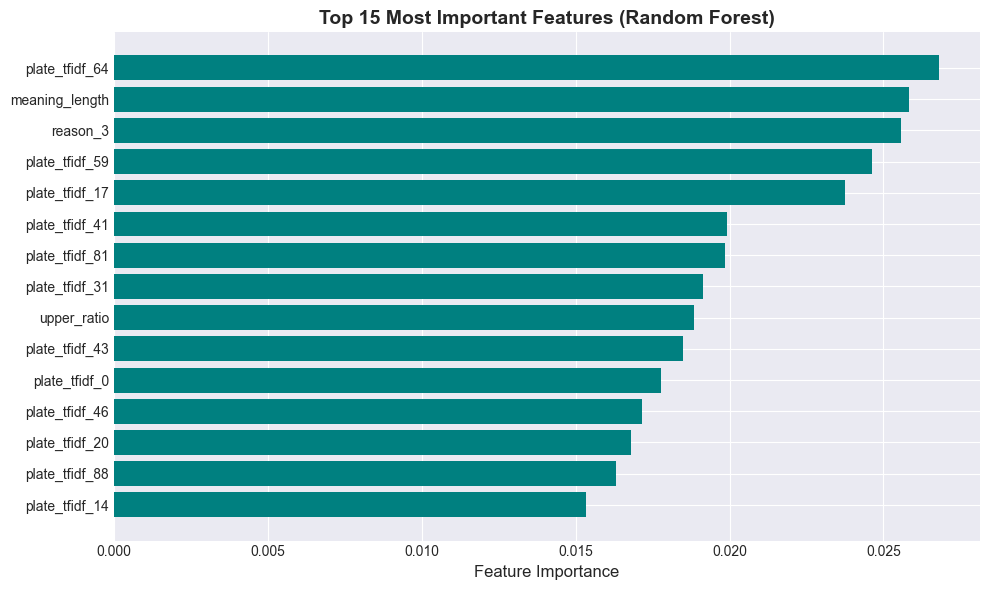

In [30]:
# Feature Importance Analysis (Random Forest)
print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature names
plate_features = [f'plate_tfidf_{i}' for i in range(X_plate_tfidf.shape[1])]
meaning_features = [f'meaning_tfidf_{i}' for i in range(X_meaning_tfidf.shape[1])]
meta_feature_names = X_meta.columns.tolist()
all_feature_names = plate_features + meaning_features + meta_feature_names

# Get importances from Random Forest
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Show top 20 features
print("\nTop 20 Most Important Features (Random Forest):")
for i in range(min(20, len(indices))):
    idx = indices[i]
    feature_name = all_feature_names[idx] if idx < len(all_feature_names) else f'feature_{idx}'
    print(f"{i+1:2d}. {feature_name:40s}: {importances[idx]:.6f}")

# Visualize top features
top_n = 15
top_indices = indices[:top_n]
top_features = [all_feature_names[i] if i < len(all_feature_names) else f'feature_{i}' 
                for i in top_indices]
top_importances = importances[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances[::-1], color='teal')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel('Feature Importance', fontsize=12)
plt.title(f'Top {top_n} Most Important Features (Random Forest)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Example Predictions Analysis
print("=" * 60)
print("EXAMPLE PREDICTIONS ANALYSIS")
print("=" * 60)

# Get test indices
test_indices = df_clean.index[X_test.shape[0]*-1:].tolist()
df_test = df_clean.loc[test_indices].copy()
df_test['predicted_status'] = ['Approved' if p == 1 else 'Denied' for p in y_pred_gb_test]
df_test['true_status'] = ['Approved' if t == 1 else 'Denied' for t in y_test]
df_test['prediction_prob'] = y_prob_gb_test
df_test['correct'] = y_test == y_pred_gb_test

print("\nExamples of correctly predicted denied applications:")
correct_denied = df_test[(df_test['true_status']=='Denied') & df_test['correct']].head(5)
for idx, row in correct_denied.iterrows():
    print(f"\nPlate: {row['plate']}")
    print(f"  Meaning: {row['customer_meaning'][:80]}..." if len(row['customer_meaning']) > 80 
          else f"  Meaning: {row['customer_meaning']}")
    print(f"  Reviewer: {row['reviewer_comments'][:80]}..." if len(row['reviewer_comments']) > 80 
          else f"  Reviewer: {row['reviewer_comments']}")
    print(f"  Prediction probability (denied): {1-row['prediction_prob']:.3f}")

print("\n" + "="*60)
print("\nExamples of correctly predicted approved applications:")
correct_approved = df_test[(df_test['true_status']=='Approved') & df_test['correct']].head(5)
for idx, row in correct_approved.iterrows():
    print(f"\nPlate: {row['plate']}")
    print(f"  Meaning: {row['customer_meaning'][:80]}..." if len(row['customer_meaning']) > 80 
          else f"  Meaning: {row['customer_meaning']}")
    print(f"  Prediction probability (approved): {row['prediction_prob']:.3f}")

print("\n" + "="*60)
print("\nExamples of incorrectly predicted applications:")
false_positives = df_test[(df_test['true_status']=='Denied') & ~df_test['correct']].head(5)
for idx, row in false_positives.iterrows():
    print(f"\nPlate: {row['plate']}")
    print(f"  Meaning: {row['customer_meaning'][:80]}..." if len(row['customer_meaning']) > 80 
          else f"  Meaning: {row['customer_meaning']}")
    print(f"  Reviewer: {row['reviewer_comments'][:80]}..." if len(row['reviewer_comments']) > 80 
          else f"  Reviewer: {row['reviewer_comments']}")
    print(f"  Incorrectly predicted as approved (prob: {row['prediction_prob']:.3f})")

EXAMPLE PREDICTIONS ANALYSIS

Examples of CORRECTLY predicted DENIED applications:

Plate: JFZME
  Meaning: MY FIRST INITIAL, MY WIFE'S FIRST INITIAL, AND THE FIRST INITIALS OF OUR CHILDRE...
  Reviewer: "J F'S ME" COULD MEAN J FUCKS ME
  Prediction probability (denied): 0.744

Plate: KIRBY88
  Meaning: NICKNAME, SAME AS THE VACUM CLEANER YEAR I WAS BORN
  Reviewer: 88, GANG REFERENCE
  Prediction probability (denied): 0.884

Plate: KSMYSIX
  Meaning: A TRIBUTE TO MY CHILDREN
  Reviewer: KISS MY SIX, "KISS MY ASS" HOSTILE
  Prediction probability (denied): 0.724

Plate: KSSMY37
  Meaning: THE 37 REFERS TO MY CAR, AN INFINITI G37.I TRULY LOVE MY CAR AND WANT OTHERS TO ...
  Reviewer: "KISS MY…" HOSTILE
  Prediction probability (denied): 0.797

Plate: LOKSKIL
  Meaning: WHEN SOMETHING LOOKS NICE, LOOKS KILL AS IN IT LOOKS NICE
  Reviewer: KILL, HOSTILE
  Prediction probability (denied): 0.812


Examples of CORRECTLY predicted APPROVED applications:

Plate: LAHUEVA
  Meaning: FEELING LAZY

In [ ]:
# Multi-Task Prediction: Status + Reason Code
print("=" * 60)
print("MULTI-TASK PREDICTION EXAMPLE")
print("=" * 60)

print("\nDemonstrating the two-stage prediction pipeline:")
print("Stage 1: Predict approval status")
print("Stage 2: If denied, predict reason code")

# Sample some test cases
sample_indices = np.random.choice(len(y_test), 10, replace=False)

for i, idx in enumerate(sample_indices):
    # Get the original data
    original_idx = test_indices[idx]
    row = df_clean.loc[original_idx]
    
    # Stage 1: Predict approval
    status_pred = y_pred_gb_test[idx]
    status_prob = y_prob_gb_test[idx]
    true_status = y_test[idx]
    
    print(f"\n{'='*60}")
    print(f"Example {i+1}:")
    print(f"Plate: {row['plate']}")
    print(f"Customer Meaning: {row['customer_meaning'][:60]}..." 
          if len(row['customer_meaning']) > 60 else f"Customer Meaning: {row['customer_meaning']}")
    print(f"\nTrue Status: {'Approved' if true_status == 1 else 'Denied'}")
    print(f"Predicted Status: {'Approved' if status_pred == 1 else 'Denied'}")
    print(f"Prediction Confidence: {status_prob if status_pred == 1 else 1-status_prob:.3f}")
    
    # Stage 2: If predicted as denied, predict reason code
    if status_pred == 0:  # Denied
        # Transform this single sample
        sample_meta = create_features_no_reason(pd.DataFrame([row]))
        sample_plate_tfidf = tfidf_plate.transform([row['plate']])
        sample_meaning_tfidf = tfidf_meaning.transform([row['customer_meaning']])
        sample_combined = hstack([sample_plate_tfidf, sample_meaning_tfidf, sample_meta.values])
        
        reason_pred = gb_reason_model.predict(sample_combined)[0]
        reason_code_pred = reason_encoder.classes_[reason_pred]
        
        print(f"\nPredicted Reason Code: {reason_code_pred}")
        if pd.notna(row['review_reason_code']):
            print(f"True Reason Code: {row['review_reason_code']}")
            print(f"Reason Code Match: {'SUCCESS:' if str(row['review_reason_code']) == str(reason_code_pred) else 'NOTE:'}")

print("\n" + "="*60)

MULTI-TASK PREDICTION EXAMPLE

Demonstrating the two-stage prediction pipeline:
Stage 1: Predict approval status
Stage 2: If denied, predict reason code

Example 1:
Plate: PUMPZ
Customer Meaning: NAME OF HIS COMPANY

True Status: Denied
Predicted Status: Denied
Prediction Confidence: 0.912

Predicted Reason Code: 1
True Reason Code: 2
Reason Code Match: ✗

Example 2:
Plate: 1O41
Customer Meaning: POLICE 10-CODE FOR 'BEGINNING TOUR OF DUTY'

True Status: Approved
Predicted Status: Approved
Prediction Confidence: 0.509

Example 3:
Plate: ALLHUSL
Customer Meaning: WORK HARD FOR EVERYTHING YOU WANT IN LIFE .

True Status: Denied
Predicted Status: Denied
Prediction Confidence: 0.898

Predicted Reason Code: 2
True Reason Code: 2
Reason Code Match: ✓

Example 4:
Plate: POOR MX
Customer Meaning: POOR MOTOCROSS RIDER (EXPENSIVE HOBBY)

True Status: Denied
Predicted Status: Denied
Prediction Confidence: 0.807

Predicted Reason Code: 1
True Reason Code: 2
Reason Code Match: ✗

Example 5:
Plate: S